# <center>Adaptive Filters</center>
***
<center>Natanael Magno Gomes <b>397645</b></center>

***
## Kalman Filter assignment

For this assignment, consider an old Volkswagen Beetle that is driving on a long straight road. Using a Kalman filter, we want to estimate the Beetle’s position on the road and the speed at which it is travelling. First based on speed measurements and then based on position measurements.<br>
1. Assume that (in theory) the Beetle is travelling at a speed of 90 km/h. 
Simulate velocity measurements by adding white noise (mean = 0 km/h, standard deviation = 20 km/h) to the theoretical speed and set the sample frequency to one sample per minute.<br> Design and build a Kalman filter (for example in Python or Octave/Matlab) to estimate the Beetle’s velocity and use the velocity estimates to derive its (one-dimensional) position on the road. (Assume at time 0 the Beetle is at km 0 along the road.) Present your results graphically and comment on them.
2. The Beetle’s owner recently bought a navigation system that uses GPS positioning. Assume again that the Beetle is travelling at a speed of 90 km/h and determine the theoretical positions of the car along the road at 1-minute intervals.<br>The road is passing through a forest, so the GPS measurements are rather noisy. Suppose that the GPS measurements give you the Beetle’s positions with additive white noise (mean = 0 m, standard deviation = 300 m) once per minute.<br>Design and build a Kalman filter to first estimate the Beetle’s position and then use the estimated positions to derive its velocity. (Again assume at time 0 the car is at km 0 along the road.)<br>Present your results graphically and comment on them.<br>Compare the new results with the results from (1) and comment on the differences (if any). 

## Solution

The vector state model of this problem is:

$$
\begin{bmatrix} s \\ v \end{bmatrix}_n
=
\begin{bmatrix} 1 & dt \\ 0 & 1 \end{bmatrix}
.
\begin{bmatrix} s \\ v \end{bmatrix}_{n-1}
$$

Where $s$ is the position, $v$ is the speed and $dt$ is the time interval between $n-1$ and $n$.<br>
There is no acceleration and no control on this system.<br>
From this we can build the Python script to solve the problem:

In [1]:
#------------------------------------------------
# Import the libraries and config the environment
#------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

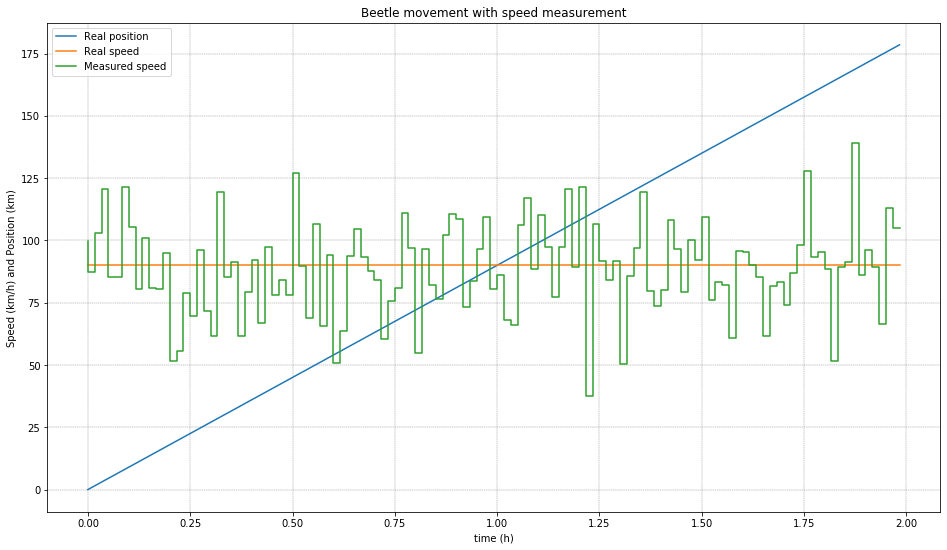

In [2]:
#------------------------------------------------
# Problem analysis - first part
#------------------------------------------------
# The Beetle is driving on a straight road so we can consider a single dimension for
# the movement. The speed is being measured.

# The time interval is 1 per minute
dt = 1/60                   # hours

# Lets consider 2 hours of driving
final_t = 2.0               # hours
t = np.arange(0,2,dt)       # hours
nsample = t.shape[0]

# The car speed is 90km/h and there is a noise with standard deviation of 20 km/h
# on the measurement.

init_speed = 90.0           # km / hour
init_position = 0.0         # km

# Real speed
v = np.repeat(init_speed,t.shape)


# Real position
s = np.zeros(v.shape)
s[0] = init_position
for i in range(1,nsample,1):
    s[i] = s[i-1] + v[i-1]*dt

# initialize the random seed
np.random.seed(42) # the answer to life the universe and everything: 42

# Noisy speed
sigma = 20.0                # km / hour
noise = np.random.normal(0,sigma,nsample)
measured_v = v + noise


# Plot
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.set_title('Beetle movement with speed measurement')
ax.plot(t,s, label='Real position')
ax.plot(t,v, label='Real speed')
ax.step(t,measured_v, label='Measured speed')
ax.set_xlabel('time (h)'), ax.grid(linestyle='--',linewidth='0.4', color='gray')
ax.set_ylabel('Speed (km/h) and Position (km)')
plt.legend()
plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
plt.show()

In the graph above we can see the measured speed of 90km/h with a standard deviation of 20km/h, it is possible to see that there is a small signal-to-noise ratio SNR.

In [3]:
#------------------------------------------------
# Kalman Filter initialization
#------------------------------------------------

# The matrix A for this problem is:
A = np.matrix([[1.0, dt],
              [0.0, 1.0]])

# The state vector initial condition is:
x = np.matrix([[init_position, init_speed]]).T

# Initial incertainty
P = 1.0*np.eye(2)

# Measurement matrix, for the first problem is just the speed
H = np.matrix([[0.0,1.0],
              [0.0,1.0]])

# Measurement noise covariance
R = np.matrix([[20 ** 2]])

# Process Noise Covariance
Q = 1.0*np.eye(2)

# Identity matrix
I = np.eye(2)

In [4]:
#------------------------------------------------
# Kalman Filter implementation
#------------------------------------------------

# Initialization of the lists
s_hat1 = []
v_hat1 = []

# Perform the Kalman Filter
i = 10
for n in range(nsample):
    
    # With more than 10 measurements update the Measurement Covariance R
    if n>i:
        R = np.matrix([np.std(measured_v[(n-i):n])**2, 0.0])
    
    #--------------------------------------------
    #           Prediction step
    #--------------------------------------------
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    #--------------------------------------------
    #            Updating step
    #--------------------------------------------
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)
    
    # Update the estimate
    y = measured_v[n] - (H*x)
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P

    # Save data
    s_hat1.append(float(x[0]))
    v_hat1.append(float(x[1]))

[]

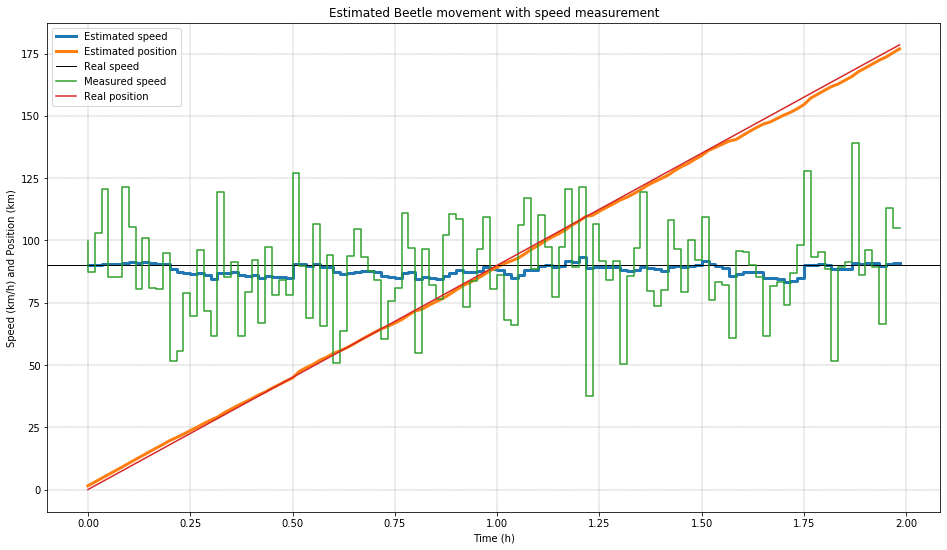

In [5]:
# Plot the result
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.step(t,v_hat1, label='Estimated speed', linewidth='3')
ax.plot(t,s_hat1, label='Estimated position', linewidth='3')
ax.axhline(90, color='black', label='Real speed', linewidth='1')
ax.step(t,measured_v, label='Measured speed')
ax.plot(t,s, label='Real position')
ax.set_xlabel('Time (h)'), ax.grid(linestyle='--',linewidth='0.4', color='gray')
ax.set_title('Estimated Beetle movement with speed measurement')
ax.legend(loc='best')
ax.set_ylabel('Speed (km/h) and Position (km)')
ax.grid(linestyle='--',linewidth='0.4', color='gray')
plt.plot()

The kalman filter is computationaly expensive but it proves to work very well with noisy data. In the result above we can see the noisy measured speed and the estimated speed, much closer to the actual speed. Even though there is a bad SNR on the measurement the filter is capable of making a good estimation of the speed and position of the Beetle.

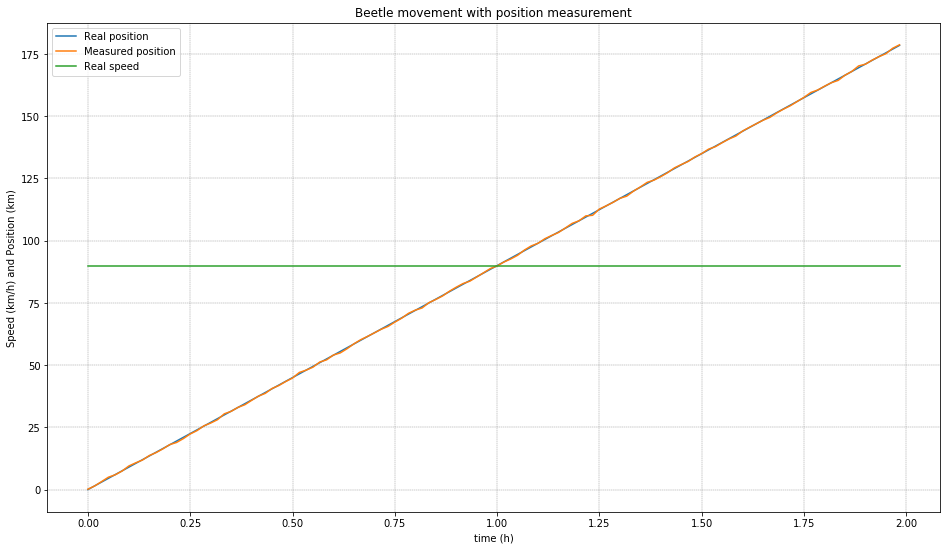

In [6]:
#------------------------------------------------
# Problem analysis - second part
#------------------------------------------------
# The Beetle is driving on a straight road so we can consider a single dimension for
# the movement. The position is being measured.

# The time interval is 1 per minute
dt = 1/60                   # hours

# Lets consider 2 hours of driving
final_t = 2.0               # hours
t = np.arange(0,2,dt)       # hours
nsample = t.shape[0]

# The car speed is 90km/h and there is a noise with standard deviation of 300m
# on the measurement of the position.

init_speed = 90.0           # km / hour
init_position = 0.0         # km

# Real speed
v = np.repeat(init_speed,t.shape)


# Real position
s = np.zeros(v.shape)
s[0] = init_position
for i in range(1,nsample,1):
    s[i] = s[i-1] + v[i-1]*dt

# initialize the random seed
np.random.seed(42) # the answer to life the universe and everything: 42

# Noisy speed
sigma = 0.3                # kilometers
noise = np.random.normal(0,sigma,nsample)
measured_s = s + noise

# Plot
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.set_title('Beetle movement with position measurement')
ax.plot(t,s, label='Real position')
ax.plot(t,measured_s, label='Measured position')
ax.plot(t,v, label='Real speed')
ax.set_xlabel('time (h)'), ax.grid(linestyle='--',linewidth='0.4', color='gray')
ax.set_ylabel('Speed (km/h) and Position (km)')
plt.legend()
plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
plt.show()

In the graph it is possible to visualise the measured position extremely close to the real position, indicating a big signal-to-noise ratio SNR.

In [7]:
#------------------------------------------------
# Kalman Filter initialization
#------------------------------------------------

# The matrix A for this problem is:
A = np.matrix([[1.0, dt],
              [0.0, 1.0]])

# The state vector initial condition is:
x = np.matrix([[init_position, init_speed]]).T
# x = np.matrix([[init_position, 0]]).T

# Initial incertainty
P = 1.0*np.eye(2)

# Measurement matrix, for the first problem is just the speed
H = np.matrix([[1.0,0.0],
              [1.0,0.0]])

# Measurement noise covariance
R = np.matrix([[0.3 ** 2]])

# Process Noise Covariance
Q = 1.0*np.eye(2)

# Identity matrix
I = np.eye(2)

In [8]:
#------------------------------------------------
# Kalman Filter implementation
#------------------------------------------------

# Initialization of the lists
s_hat2 = []
v_hat2 = []

# Perform the Kalman Filter
i = 10
for n in range(nsample):
    
    # With more than 10 measurements update the Measurement Covariance R
    if n>i:
        R = np.matrix([np.std(measured_s[(n-i):n])**2, 0.0])
    
    #--------------------------------------------
    #           Prediction step
    #--------------------------------------------
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    #--------------------------------------------
    #            Updating step
    #--------------------------------------------
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)
    
    # Update the estimate
    y = measured_s[n] - (H*x)
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P

    # Save states for Plotting
    s_hat2.append(float(x[0]))
    v_hat2.append(float(x[1]))

[]

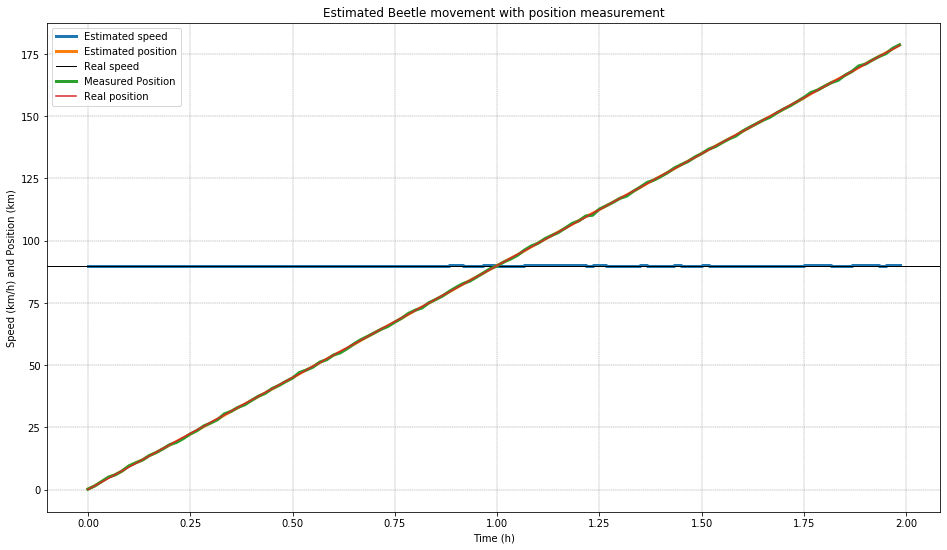

In [9]:
# Plot the result
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.step(t,v_hat2, label='Estimated speed', linewidth='3')
ax.plot(t,s_hat2, label='Estimated position', linewidth='3')
ax.axhline(90, color='black', label='Real speed', linewidth='1')
ax.plot(t,measured_s, label='Measured Position', linewidth='3')
ax.plot(t,s, label='Real position')
ax.set_xlabel('Time (h)'), ax.grid(linestyle='--',linewidth='0.4', color='gray')
ax.set_title('Estimated Beetle movement with position measurement')
ax.legend(loc='best')
ax.set_ylabel('Speed (km/h) and Position (km)')
ax.grid(linestyle='--',linewidth='0.4', color='gray')
plt.plot()

The estimation of the position is incredbly good, as expected. This happens for two reasons, the SNR of the measured position is smaller than the measured speed and the position is estimated without integrating the speed, which could accumulate errors.<br>Let's plot the errors.

[]

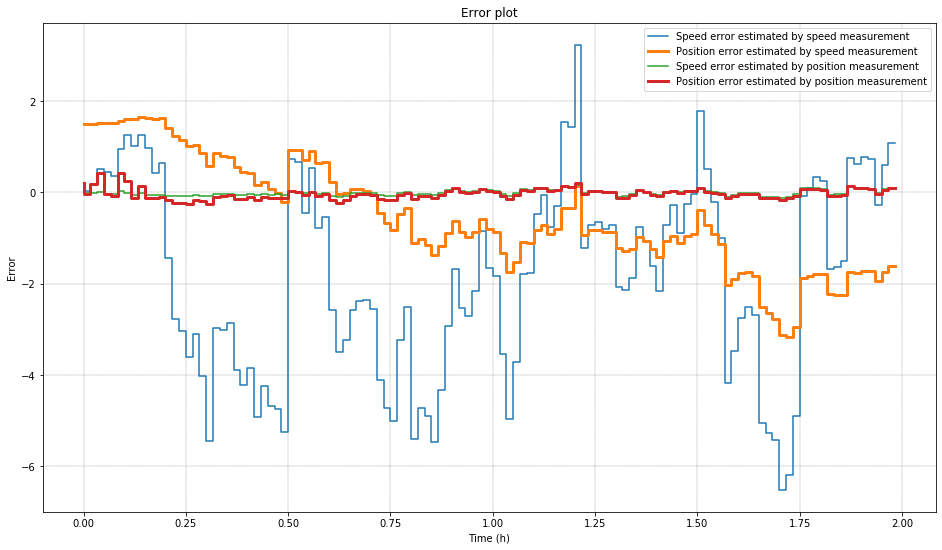

In [10]:
# Plot the errors
fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.step(t,v_hat1-v, label='Speed error estimated by speed measurement')#, linewidth='3')
ax.step(t,s_hat1-s, label='Position error estimated by speed measurement', linewidth='3')
# ax.axhline(90, color='black', label='Real speed', linewidth='1')
# ax.plot(t,measured_s, label='Measured speed', linewidth='3')
ax.step(t,v_hat2-v, label='Speed error estimated by position measurement')#, linewidth='3')
ax.step(t,s_hat2-s, label='Position error estimated by position measurement', linewidth='3')

ax.set_xlabel('Time (h)'), ax.grid(linestyle='--',linewidth='0.4', color='gray')
ax.set_title('Error plot')
ax.legend(loc='best')
ax.set_ylabel('Error')
ax.grid(linestyle='--',linewidth='0.4', color='gray')
plt.plot()

Is clear on the graph above that the estimation made by position measurement is much better than the estimation by speed measurement in both speed and position estimation.

## Conclusion

The Kalman filter is great for estimating the state of a system when there are noisy measurements. Although it works better when the measurement does not need integration to estimate the state of the system, since integration can accumulate errors through time.